In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
%load_ext google.cloud.bigquery

from IPython.display import clear_output
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)
#sns.set_style('darkgrid', {"xtick.minor.size": 10, "ytick.major.size": 10})
current_palette = sns.color_palette('deep')
#sns.palplot(current_palette)

# 1. Creating a Mapping between Application number and PatStat Application ID

## 1.1. Investigating how to extract "appln_kind" and "appln_auth" from "Application_number" in Google Patents Public Dataset

In [4]:
%%bigquery df_1
WITH t1 AS(
    SELECT a.application_number AS appln_nr_orig, a.publication_number AS publn_nr_orig, country_code AS appln_auth, application_kind AS appln_kind, 
    PC.application_number AS prior_appln_nr_orig, PC.publication_number AS prior_publn_nr_orig
    FROM `patents-public-data.patents.publications` AS a, UNNEST(a.priority_claim) AS PC
), t2 AS(
    SELECT DISTINCT
        appln_nr_orig,
        publn_nr_orig,
        appln_auth,
        appln_kind
    FROM t1
)

SELECT
    COUNT(CASE WHEN REGEXP_EXTRACT(appln_nr_orig, r'(\w{2})-.*-.*')=appln_auth THEN 1 END) AS nb_appln_auth_matched,
    COUNT(CASE WHEN REGEXP_EXTRACT(publn_nr_orig, r'(\w{2})-.*-.*')=appln_auth THEN 1 END) AS nb_publn_auth_matched,
    COUNT(CASE WHEN REGEXP_EXTRACT(appln_nr_orig, r'\w{2}-.*-(\w{1}).*')=appln_kind THEN 1 END) AS nb_appln_kind_matched,
    COUNT(CASE WHEN REGEXP_EXTRACT(publn_nr_orig, r'\w{2}-.*-(\w{1}).*')=appln_kind THEN 1 END) AS nb_publn_kind_matched,
    COUNT(*) AS nb_total
FROM t2

,nb_appln_auth_matched,nb_publn_auth_matched,nb_appln_kind_matched,nb_publn_kind_matched,nb_total
0,108185073,112527100,112492646,75692551,112527100


Thus, this shows that for extracting `appln_kind` we should use `application_number` field, but for extracting `appln_auth` we must use `publication_number`!

## 1.2. Running the query for generating the mapping dataset

In [8]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '10_mapping_initial'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
WITH t1 AS(
    SELECT a.application_number AS appln_nr_orig, a.publication_number AS publn_nr_orig, PC.application_number AS prior_appln_nr_orig, PC.publication_number AS prior_publn_nr_orig
    FROM `patents-public-data.patents.publications` AS a, UNNEST(a.priority_claim) AS PC
), t2 AS(
    SELECT DISTINCT
        appln_nr_orig,
        publn_nr_orig
    FROM t1
), t3 AS(
    SELECT DISTINCT
        prior_appln_nr_orig AS appln_nr_orig,
        prior_publn_nr_orig AS publn_nr_orig
    FROM t1
), t4 AS(
    SELECT DISTINCT *
    FROM(
        (SELECT appln_nr_orig, publn_nr_orig
        FROM t2) UNION ALL
        (SELECT appln_nr_orig, publn_nr_orig
        FROM t3)
    )
), t5 AS(
    SELECT DISTINCT 
        appln_nr_orig,
        appln_nr,
        (CASE WHEN appln_auth_p IS NOT NULL THEN appln_auth_p ELSE appln_auth_a END) AS appln_auth,
        appln_kind
    FROM(
        SELECT DISTINCT
            appln_nr_orig,
            REGEXP_EXTRACT(appln_nr_orig, r'\w{2}-(.*)-.*') AS appln_nr,
            REGEXP_EXTRACT(publn_nr_orig, r'(\w{2})-.*-.*') AS appln_auth_p,
            REGEXP_EXTRACT(appln_nr_orig, r'(\w{2})-.*-.*') AS appln_auth_a,
            REGEXP_EXTRACT(appln_nr_orig, r'\w{2}-.*-(\w{1}).*') AS appln_kind
        FROM t4
    )
    #WHERE appln_auth IS NOT NULL
), t6 AS(
    SELECT DISTINCT
      appln_id, 
      appln_nr, 
      appln_auth,
      REGEXP_EXTRACT(appln_kind, r'(\w{1}).*') AS appln_kind,
      receiving_office
    FROM `usptobias.patstat.tls201`
), t7 AS(
    SELECT *
    FROM t5
    FULL OUTER JOIN t6 USING(appln_nr, appln_auth, appln_kind)
), t8 AS(
    SELECT 
        appln_id, 
        ANY_VALUE(appln_kind) AS appln_kind, 
        ANY_VALUE(appln_auth) AS appln_auth, 
        ARRAY_AGG(appln_nr_orig) AS appln_nr_orig, 
        ANY_VALUE(appln_nr) AS appln_nr
    FROM t7
    GROUP BY appln_id
    HAVING COUNT(t7.appln_nr_orig)>1
), t9 AS(
    SELECT 
        appln_nr_orig,
        ANY_VALUE(appln_id) AS appln_id
    FROM t7
    GROUP BY appln_nr_orig
    HAVING COUNT(t7.appln_id)>1
), t10 AS(
    SELECT 
        t8.appln_id,
        t8.appln_kind,
        t8.appln_auth,
        t8.appln_nr,
        appln_nr_orig_ex AS appln_nr_orig
    FROM t8, UNNEST(t8.appln_nr_orig) AS appln_nr_orig_ex
    LEFT JOIN t6 USING(appln_id)
    WHERE t6.receiving_office = REGEXP_EXTRACT(appln_nr_orig_ex, r'(\w{2})-.*-.*')
), t11 AS(
    SELECT a.*
    FROM(
        SELECT 
            t7.appln_id,
            t7.appln_kind,
            t7.appln_auth,
            t7.appln_nr,
            t7.appln_nr_orig
        FROM t7
        LEFT JOIN t8 USING(appln_id)
        WHERE t8.appln_kind IS NULL
    ) AS a
    LEFT JOIN t9 USING(appln_nr_orig)
    WHERE t9.appln_id IS NULL

)

SELECT DISTINCT *
FROM(
    (SELECT * FROM t11) UNION ALL
    (SELECT * FROM t10)
)

"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [30]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '10_mapping'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
SELECT DISTINCT *
FROM `usptobias.adding_data.10_mapping_initial`
WHERE (appln_id IS NOT NULL) AND (appln_nr_orig IS NOT NULL)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

## 1.3. Investigating the Quality of Mapping

In [ ]:
# Checking total number of remaining cases After removing NULLs

In [32]:
%%bigquery
SELECT COUNT(*) AS nb_matched
FROM `usptobias.adding_data.10_mapping`

,nb_matched
0,92744715


In [ ]:
## Checking Total number of cases

In [33]:
%%bigquery
SELECT COUNT(*) AS nb_matched
FROM `usptobias.adding_data.10_mapping_initial`

,nb_matched
0,100623513


In [ ]:
## The new One
## Checking how many application number did not matched with an application ID in PatStat (nb_not_matched) 
##... and how many application IDs did not exist in Google Patent Public Dataset (nb_not_existed)

In [34]:
%%bigquery df_2
SELECT
    COUNT(CASE WHEN appln_id IS NULL THEN 1 END) AS nb_not_matched,
    COUNT(CASE WHEN (appln_nr_orig IS NULL) AND (appln_id>900000000) THEN 1 END) AS nb_artificial_not_existed,
    COUNT(CASE WHEN (appln_nr_orig IS NULL) AND (appln_id<=900000000) THEN 1 END) AS nb_docdb_not_existed,
    COUNT(appln_nr) AS nb_total
FROM `usptobias.adding_data.10_mapping_initial`
LIMIT 10

,nb_not_matched,nb_artificial_not_existed,nb_docdb_not_existed,nb_total
0,3976244,1884651,2017903,100623481


In [35]:
print('There were {:,} cases with an "Application Number" in GOOGLE PATENTS but no corresponding "Application ID" in PATSTAT.\n'
      .format(df_2.loc[0, 'nb_not_matched']))
print('There were {:,} cases with no corresponding "Application Number" in GOOGLE PATENTS but an artificial "Application ID" in PATSTAT.\n'
      .format(df_2.loc[0, 'nb_artificial_not_existed']))
print('There were {:,} cases with no corresponding "Application Number" in GOOGLE PATENTS but an DOCDB "Application ID" in PATSTAT.\n'
      .format(df_2.loc[0, 'nb_docdb_not_existed']))

There were 3,976,244 cases with an "Application Number" in GOOGLE PATENTS but no corresponding "Application ID" in PATSTAT.

There were 1,884,651 cases with no corresponding "Application Number" in GOOGLE PATENTS but an artificial "Application ID" in PATSTAT.

There were 2,017,903 cases with no corresponding "Application Number" in GOOGLE PATENTS but an DOCDB "Application ID" in PATSTAT.



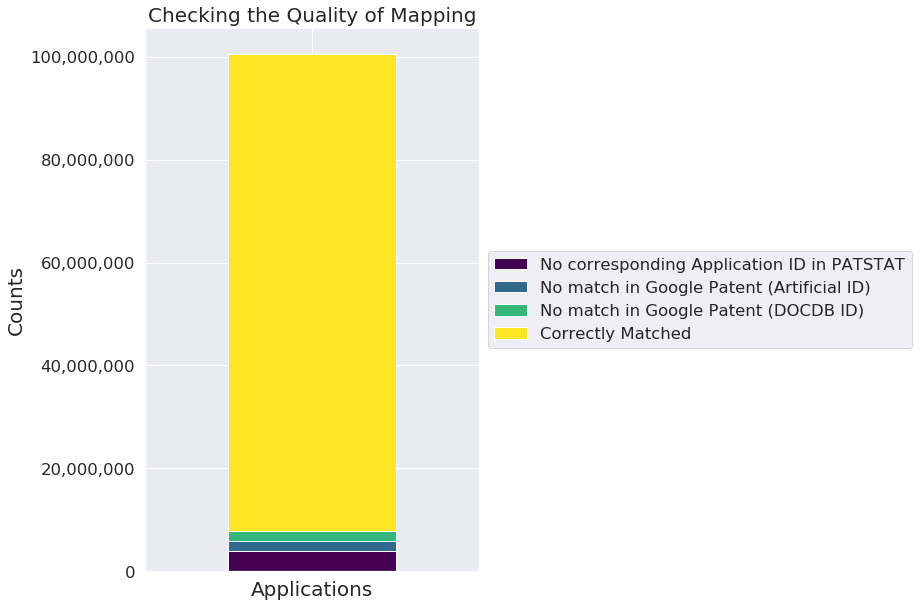

In [36]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(6,10))
df_2['matched'] = df_2.iloc[:,3] - df_2.iloc[:,:3].sum(axis=1)
df_plot = df_2.iloc[:,np.r_[0:3,4]]
df_plot.index = ['Applications']
df_plot.columns = ['No corresponding Application ID in PATSTAT', 'No match in Google Patent (Artificial ID)', 
                   'No match in Google Patent (DOCDB ID)', 'Correctly Matched']
df_plot.plot(ax=ax, kind='bar', stacked=True, colormap='viridis')
ax.bar
#ax.set_xlabel('Sex', fontsize=18)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('Checking the Quality of Mapping', fontsize=20)
ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_ylim(1e5,1e8)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')


plt.show()

In [ ]:
## Checking if a PATSTAT "Application ID" is Mapped to several Google "Application Number" or
##... a Google "Application Number" is matched to more than one "Application ID" in PATSTAT

In [7]:
%%bigquery df_2

WITH a AS(
    SELECT (COUNT(*)-1) AS nb_invalid_appln_id
    FROM(
        SELECT appln_id, ARRAY_AGG(DISTINCT appln_nr_orig)
        FROM `usptobias.adding_data.10_mapping`
        GROUP BY appln_id
        HAVING COUNT(appln_nr_orig)>1
    )

), b AS(
    SELECT (COUNT(*)-1) AS nb_invalid_appln_nr_orig
    FROM(
        SELECT appln_nr_orig, ARRAY_AGG(DISTINCT appln_id) AS appln_id
        FROM `usptobias.adding_data.10_mapping` AS t1
        GROUP BY appln_nr_orig
        HAVING COUNT(t1.appln_id)>1
    )

)

SELECT *
FROM a, b
LIMIT 100

,nb_invalid_appln_id,nb_invalid_appln_nr_orig
0,0,0


# 2. Creating a Backbone of Google Patents Data

In [38]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '11_google_backbone'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
SELECT 
    application_number,
    publication_number,
    country_code, 
    kind_code, 
    application_kind,
    family_id,
    publication_date, 
    filing_date,
    grant_date,
    ARRAY_LENGTH(examiner) AS nb_examiners,
    ARRAY_LENGTH(inventor) AS nb_inventors,
    ARRAY_LENGTH(assignee) AS nb_assignee,
    inventor,
    assignee,
    examiner
FROM 
    `patents-public-data.patents.publications` AS a
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 3. Adding Exact Twins Information

In [ ]:
# Adding exact twins info (This table was built in 04-Customized_Algorithm Notebook)

In [132]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '12_exact_twins'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
SELECT *
FROM 
    `usptobias.custom_alg.step_03_twins`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 4. Adding Examiners Information

## 3.1. Evaluating Google Patents' Dataset Quality for Examiners

In [70]:
%%bigquery df_1
WITH t1 AS(
    SELECT 
        country_code, 
        COUNT(DISTINCT(CASE WHEN nb_examiners>0 THEN application_number END)) AS examiners_avail, 
        COUNT(DISTINCT(CASE WHEN nb_examiners=0 THEN application_number END)) AS examiners_unavail, 
        COUNT(DISTINCT application_number) AS nb_total_appln
    FROM(SELECT *
        FROM `usptobias.adding_data.11_google_backbone`) 
    GROUP BY country_code)
SELECT *
FROM t1
WHERE examiners_avail>0
ORDER BY country_code
LIMIT 100

,country_code,examiners_avail,examiners_unavail,nb_total_appln
0,CN,1190543,17871483,17871527
1,ES,19568,1293072,1309543
2,JP,1447545,18228414,18232679
3,KR,2219617,2704427,3732274
4,TW,14996,1316385,1319282
5,US,6893454,9512821,13093687


In [69]:
%%bigquery df_2
WITH t1 AS(
    SELECT 
        country_code, 
        COUNT(DISTINCT(CASE WHEN nb_examiners>0 THEN application_number END)) AS examiners_avail, 
        COUNT(DISTINCT(CASE WHEN nb_examiners=0 THEN application_number END)) AS examiners_unavail, 
        COUNT(DISTINCT application_number) AS nb_total_appln
    FROM(SELECT *
        FROM `usptobias.adding_data.11_google_backbone` 
        WHERE filing_date>20010101) 
    GROUP BY country_code)
SELECT *
FROM t1
WHERE examiners_avail>0
ORDER BY country_code
LIMIT 100

,country_code,examiners_avail,examiners_unavail,nb_total_appln
0,CN,1184071,17053646,17053686
1,ES,18154,313812,330077
2,JP,11597,5884264,5884312
3,KR,1615294,2274453,2813533
4,TW,14996,1111061,1113958
5,US,3981700,5538077,6244220


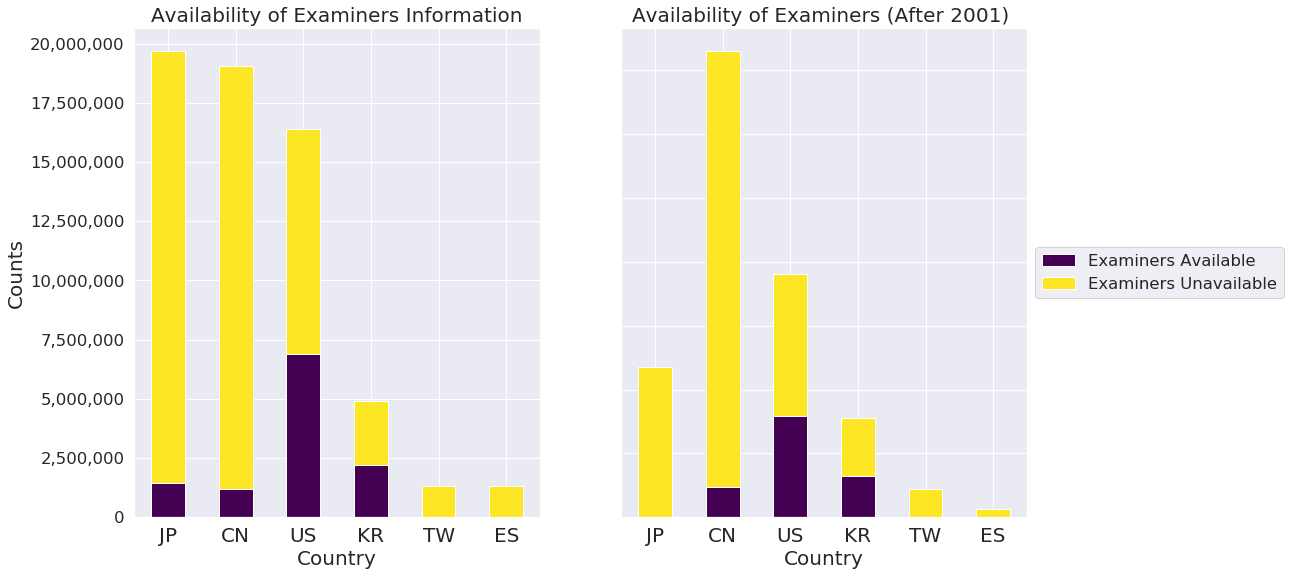

In [75]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 2, figsize=(16,9))

# First Plot (all the times)
df_1 = df_1.sort_values(by=['nb_total_appln'], ascending=False)
df_plot1 = df_1.set_index('country_code').loc[:,['examiners_avail', 'examiners_unavail']].copy()
df_plot1.columns = ["Examiners Available", 'Examiners Unavailable']
df_plot1.plot(ax=ax[0], kind='bar', stacked=True, colormap='viridis')
ax[0].bar
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_xlabel('Country', fontsize=20)
ax[0].set_title('Availability of Examiners Information', fontsize=20)
ax[0].legend(loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')
ax[0].get_legend().remove()

# Second Plot (Only after 2000)
df_plot2 = df_2.set_index('country_code').loc[:,['examiners_avail', 'examiners_unavail']].copy()
df_plot2.columns = ["Examiners Available", 'Examiners Unavailable']
df_plot2 = df_plot2.reindex(df_plot1.index)
df_plot2.plot(ax=ax[1], kind='bar', stacked=True, colormap='viridis')
ax[1].bar
ax[1].set_xlabel('Country', fontsize=20)
ax[1].set_title('Availability of Examiners (After 2001) ', fontsize=20)
ax[1].legend(loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
ax[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')
ax[1].set_yticklabels([])

plt.show()

## 4.2. Examining USPTO Patent Examination Research Data "PAIR" Table Quality for Adding Examiners

In [76]:
# Getting the distribution of patents over different application Types

In [120]:
%%bigquery df_
WITH t1 AS(
    SELECT *, CAST(REGEXP_EXTRACT(filing_date, r'(\d{4})-\d{2}-\d{2}') AS INT64) AS filing_year
    FROM `patents-public-data.uspto_oce_pair.application_data`
)

SELECT application_type, COUNT(application_number) AS nb_per_type
FROM t1
GROUP BY application_type

,application_type,nb_per_type
0,REGULAR,7996484
1,PROVSNL,930838
2,REISSUE,24779
3,REEXAM,15905
4,PCT,849685
5,?,2


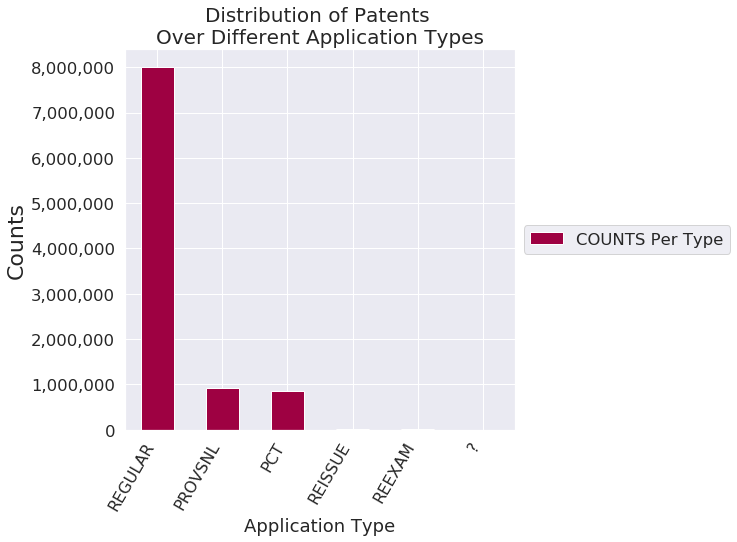

In [121]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(7,7))
df_plot = df_.sort_values(by=['nb_per_type'], ascending=False).copy()
df_plot.columns = ["Application Type", "COUNTS Per Type"]
df_plot = df_plot.set_index("Application Type").copy()
df_plot.plot(ax=ax, kind='bar', stacked=True, colormap='Spectral')
ax.bar
ax.set_ylabel('Counts', fontsize=22)
ax.set_title('Distribution of Patents \nOver Different Application Types', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':16}, rotation = 60, ha='right')
plt.show()

In [ ]:
# Querying the existance of examiner information

In [122]:
%%bigquery df_
WITH t1 AS(
    SELECT *, CAST(REGEXP_EXTRACT(filing_date, r'(\d{4})-\d{2}-\d{2}') AS INT64) AS filing_year
    FROM `patents-public-data.uspto_oce_pair.application_data`
    WHERE application_type='REGULAR'
)

SELECT 
    COUNT(CASE WHEN examiner_id IS NULL THEN 1 END) AS nb_examiner_unavail,
    COUNT(CASE WHEN examiner_id IS NOT NULL THEN 1 END) AS nb_examiner_avail,
    COUNT(*) AS nb_total_appln
FROM t1

,nb_examiner_unavail,nb_examiner_avail,nb_total_appln
0,168636,7827848,7996484


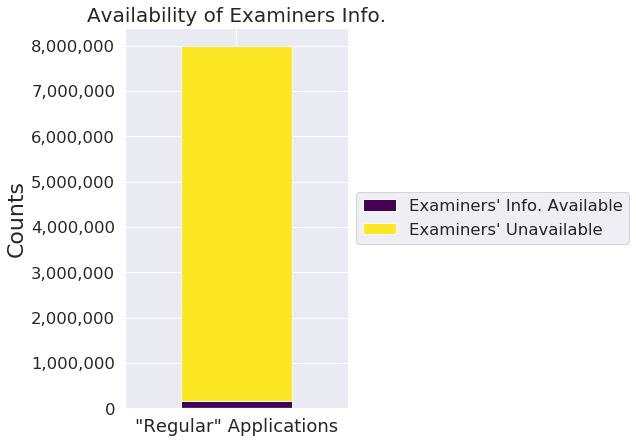

In [129]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(4,7))
df_plot = df_.iloc[:,:2].copy()
df_plot.columns = ["Examiners' Info. Available", "Examiners' Unavailable"]
df_plot.index = ['"Regular" Applications']
df_plot.plot(ax=ax, kind='bar', stacked=True, colormap='viridis')
ax.bar
ax.set_ylabel('Counts', fontsize=22)
ax.set_title('Availability of Examiners Info.', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':18}, rotation = 'horizontal')
plt.show()

## 4.3. Adding Examiners Info. Using USPTO Patent Examination Research Data "PAIR" Table

In [ ]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'adding_data'
table_id = '13_twins_AddedUSPTO'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
WITH t1 AS(
    SELECT *, CAST(REGEXP_EXTRACT(filing_date, r'(\d{4})-\d{2}-\d{2}') AS INT64) AS filing_year
    FROM `patents-public-data.uspto_oce_pair.application_data`
   
), t2 AS(
    SELECT 
        a.application_number_pair AS application_number,
        a.application_number AS appln_nr_orig
    FROM `patents-public-data.uspto_oce_pair.match` AS a
), t3 AS(
    SELECT t1.*, t2.appln_nr_orig
    FROM t1
    LEFT JOIN t2 USING(application_number)
), t4 AS(
    SELECT a.*, t2.appln_nr_orig
    FROM(
        SELECT 
            application_number,
            ARRAY_AGG(STRUCT(event_code, recorded_date, sequence_number, status_code)) AS transactions
        FROM `patents-public-data.uspto_oce_pair.transactions` AS a
        GROUP BY application_number
        
    ) AS a
    LEFT JOIN t2 USING(application_number)
), t5 AS(
    SELECT a.*, b.application_number AS appln_nr_orig
    FROM(
        SELECT 
            a.patentCaseMetadata.applicationNumberText.value AS application_number,
            ARRAY_AGG(name.personFullName) AS examiner_fullName,
            ARRAY_AGG(a.patentCaseMetadata.patentGrantIdentification.grantDate) AS grant_date,
            ANY_VALUE(a.prosecutionHistoryDataOrPatentTermData) AS actions
        FROM 
            `patents-public-data.uspto_peds.applications` AS a,	
            UNNEST(a.patentCaseMetadata.partyBag.applicantBagOrInventorBagOrOwnerBag) AS bag,
            UNNEST(bag.primaryExaminerOrAssistantExaminerOrAuthorizedOfficer) AS PE,
            UNNEST(PE.name.personNameOrOrganizationNameOrEntityName) AS name
        GROUP BY application_number
            
    ) AS a
    LEFT JOIN `patents-public-data.uspto_peds.match` AS b 
    ON a.application_number = b.applicationNumberText
), t6 AS(
    SELECT a.*, b.appln_nr_orig AS appln_nr_orig_2
    FROM(
        SELECT a.*, b.appln_nr_orig AS appln_nr_orig_1
        FROM `usptobias.adding_data.12_exact_twins` AS a
        LEFT JOIN `usptobias.adding_data.10_mapping` AS b ON a.appln_id_1=b.appln_id
    ) AS a LEFT JOIN  `usptobias.adding_data.10_mapping` AS b ON a.appln_id_2=b.appln_id
), t7 AS(
    SELECT 
        t6.*,
        t4.transactions AS transactions_US,
        t5.examiner_fullName AS examiner_fullName_US,
        t5.grant_date AS grant_date_US,
        t5.actions AS actiona_US
    FROM t6
    LEFT JOIN t4 ON t6.appln_nr_orig_1=t4.appln_nr_orig
    LEFT JOIN t5 ON t6.appln_nr_orig_1=t5.appln_nr_orig
)

SELECT 
    t7.*,
    t3.application_type AS application_type_US,
    t3.filing_date AS filing_date_US,
    t3.customer_number AS customer_number_US,
    t3.atty_docket_number AS attorney_number_US,
    t3.appl_status_code AS status_code_US,
    t3.appl_status_date AS status_date_US,
    t3.patent_number AS patent_nr_US,
    t3.patent_issue_date AS issue_date_US,
    t3.abandon_date AS abandon_date_US,
    t3.small_entity_indicator AS small_entity_US,
    t3.disposal_type AS disposal_type_US,
    STRUCT(examiner_name_last AS last, examiner_name_first AS first, examiner_name_middle AS middle) AS examiner_name_US,
    t3.examiner_id AS examiner_id_US,
    t3.examiner_art_unit AS examiner_art_unit_US
    
FROM t7
LEFT JOIN t3 ON t7.appln_nr_orig_1=t3.appln_nr_orig
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()